# Load necessary packages and define handy functions

In [1]:
# Standard modules
import sys

# 3rd party modules
import xarray as xr
import numpy as np
from scipy import integrate
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.ticker as mticker
import matplotlib as mpl
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cftime


# we add our 'cesm_tools' directory to pythons look-up path
# then we can import python files using the 'import command'
sys.path.insert(0, "/home/slingbeek/scripts/cesm_tools/")
import cesm_scenarios2 # 'cesm_scenarios' contains the 'Scenario' class

# to suppress annoying warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
def surf_mean(field):
    weights = np.cos(np.deg2rad(field.lat))
    weighted = field.weighted(weights)
    return weighted.mean(('lon','lat'))

In [3]:
def time_mean(field):
    ds = field
    ds['tw'] = (ds.time_bnds[:,1].astype("datetime64[ns]") - ds.time_bnds[:,0].astype("datetime64[ns]")).dt.days
    return ds.weighted(ds.tw).mean('time', keep_attrs=True).drop('tw')

In [4]:
def to_monthly(ds):
    year = ds.time.dt.year
    month = ds.time.dt.month

    # assign new coords
    ds = ds.assign_coords(year=("time", year.data), month=("time", month.data))

    # reshape the array to (..., "month", "year")
    return ds.set_index(time=("year", "month")).unstack("time")

In [5]:
p_ref = 100000
cp = 1004
Rdry = 286.9
kappa = Rdry/cp

def theta(ds):
    return ds.T*(p_ref/ds.plev)**kappa

def theta2(ds, var):
    return ds[var]*(p_ref/ds.plev)**kappa


In [6]:
Omega = 7.2921e-5
R = 286.9
a = 6.371e6

def Twind(t, u):
    t = t.isel(plev=slice(None, None, -1))
    
    slice_p = slice(850,5)
    
    f0 = 2*Omega*np.sin(np.deg2rad(t.lat))
    
    def uT_func(dset):
        return -(R/f0)*(dset.sel(plev=slice_p).T.differentiate(coord='lat'))/((np.pi/180)*a)*np.log(dset.plev.sel(plev=slice_p)/dset.plev.shift(plev=-1).sel(plev=slice_p))
        
    def vT_func(dset):
        return (R/f0)*(dset.sel(plev=slice_p).T.differentiate(coord='lon'))/((np.pi/180)*a*np.cos(np.deg2rad(dset.lat)))*np.log(dset.plev.sel(plev=slice_p)/dset.plev.shift(plev=-1).sel(plev=slice_p))
        
    uT = uT_func(t).cumsum(dim='plev')+u.U.sel(plev=887.)
    vT = vT_func(t).cumsum(dim='plev')
    
    return xr.Dataset({'uT':uT, 'vT':vT, 'time_bnds':t.time_bnds}).assign_attrs(t.attrs)
    
    

In [7]:
def add_headers(
    fig,
    *,
    row_headers=None,
    col_headers=None,
    row_pad=1,
    col_pad=5,
    rotate_row_headers=True,
    **text_kwargs
):
    # Based on https://stackoverflow.com/a/25814386

    axes = fig.get_axes()

    for ax in axes:
        sbs = ax.get_subplotspec()

        # Putting headers on cols
        if (col_headers is not None) and sbs.is_first_row():
            ax.annotate(
                col_headers[sbs.colspan.start],
                xy=(0.5, 1),
                xytext=(0, col_pad),
                xycoords="axes fraction",
                textcoords="offset points",
                ha="center",
                va="baseline",
                **text_kwargs,
            )

        # Putting headers on rows
        if (row_headers is not None) and sbs.is_first_col():
            ax.annotate(
                row_headers[sbs.rowspan.start],
                xy=(0, 0.5),
                xytext=(-ax.yaxis.labelpad - row_pad, 0),
                xycoords=ax.yaxis.label,
                textcoords="offset points",
                ha="right",
                va="center",
                rotation=rotate_row_headers * 90,
                **text_kwargs,
            )

In [8]:
save = True
imgsize1 = (7.48,5)
imgsize2 = (7.48,9)

plt.rcParams.update({'font.size': 8})
plt.rcParams['hatch.linewidth'] = 0.5
plt.rcParams['figure.dpi'] = 300

slice_i = slice('2016','2035')
slice_f = slice('2111','2130')

scens = ['i_c', 'f_c', 'f_20', 'f_80']#, 'i_20']
scensJJA = ['iJJA_c', 'fJJA_c', 'fJJA_20', 'fJJA_80']#, 'iJJA_20']
scensDJF = ['iDJF_c', 'fDJF_c', 'fDJF_20', 'fDJF_80']#, 'iDJF_20']

diffscens = ['cref', '20ref', '80ref']
diffscensJJA = ['crefJJA', '20refJJA', '80refJJA']
diffscensDJF = ['crefDJF', '20refDJF', '80refDJF']

savepath = '/home/slingbeek/git_map/MScThesis/TeX/images/'


# Define scenarios and load data

In [9]:
# Meta data
dir = '/home/slingbeek/cesm2_data/monthly'
cases_cnt = {'b.e21.BSSP585cmip6.f09_g17.control.01': {'directory': dir, 'years': np.arange(2015,2100)},
             'b.e21.BSSP585cmip6.f09_g17.control.06': {'directory': dir, 'years': np.arange(2100,2131)}
}
cases_sai20 = {'b.e21.BSSP585cmip6.f09_g17.2020feedback.01': {'directory': dir,'years': np.arange(2020,2045)},
               'b.e21.BSSP585cmip6.f09_g17.2020feedback.02': {'directory': dir,'years': np.arange(2045,2100)},
               'b.e21.BSSP585cmip6.f09_g17.2020feedback.02_ext02': {'directory': dir,'years': np.arange(2100,2131)}
}
cases_sai80 = {'b.e21.BSSP585cmip6.f09_g17.feedback.05': {'directory': dir, 'years': np.arange(2080,2086)},
               'b.e21.BSSP585cmip6.f09_g17.feedback.06': {'directory': dir, 'years': np.arange(2086,2100)},
               'b.e21.BSSP585cmip6.f09_g17.2080feedback_ext01': {'directory': dir, 'years': np.arange(2100,2131)}
}

cases = [cases_cnt, cases_sai20, cases_sai80]
scenario_names = ['Control', 'SAI 2020', 'SAI 2080']

# Define dictionary
scenarios = {name: cesm_scenarios2.Scenario(name,case) for name, case in zip(scenario_names,cases)}


In [10]:
# load data
scenarios['Control'].get_atm_var2('U')
scenarios['SAI 2020'].get_atm_var2('U')
scenarios['SAI 2080'].get_atm_var2('U')

scenarios['Control']['U']['plev'] = scenarios['Control']['U']['plev']/100
scenarios['SAI 2020']['U']['plev'] = scenarios['SAI 2020']['U']['plev']/100
scenarios['SAI 2080']['U']['plev'] = scenarios['SAI 2080']['U']['plev']/100


scenarios['Control'].get_atm_var2('V')
scenarios['SAI 2020'].get_atm_var2('V')
scenarios['SAI 2080'].get_atm_var2('V')

scenarios['Control']['V']['plev'] = scenarios['Control']['V']['plev']/100
scenarios['SAI 2020']['V']['plev'] = scenarios['SAI 2020']['V']['plev']/100
scenarios['SAI 2080']['V']['plev'] = scenarios['SAI 2080']['V']['plev']/100


scenarios['Control'].get_atm_var2('T')
scenarios['SAI 2020'].get_atm_var2('T')
scenarios['SAI 2080'].get_atm_var2('T')

scenarios['Control']['T']['theta'] = theta(scenarios['Control']['T'])
scenarios['SAI 2020']['T']['theta'] = theta(scenarios['SAI 2020']['T'])
scenarios['SAI 2080']['T']['theta'] = theta(scenarios['SAI 2080']['T'])

scenarios['Control']['T']['plev'] = scenarios['Control']['T']['plev']/100
scenarios['SAI 2020']['T']['plev'] = scenarios['SAI 2020']['T']['plev']/100
scenarios['SAI 2080']['T']['plev'] = scenarios['SAI 2080']['T']['plev']/100


In [11]:
latmin = -85.0
latmax = -0.

### select data at right time and high lat
U = {
    'f_c':scenarios['Control']['U'].sel(time=slice_f).sel(lat=slice(latmin,latmax)),
    'i_c':scenarios['Control']['U'].sel(time=slice_i).sel(lat=slice(latmin,latmax)),

    'f_20':scenarios['SAI 2020']['U'].sel(time=slice_f).sel(lat=slice(latmin,latmax)),
    'i_20':scenarios['SAI 2020']['U'].sel(time=slice_i).sel(lat=slice(latmin,latmax)),

    'f_80':scenarios['SAI 2080']['U'].sel(time=slice_f).sel(lat=slice(latmin,latmax)),
    
    'fJJA_c':scenarios['Control']['U'].sel(time=scenarios['Control']['U'].time.dt.season=='JJA').sel(time=slice_f).sel(lat=slice(latmin,latmax)),
    'iJJA_c':scenarios['Control']['U'].sel(time=scenarios['Control']['U'].time.dt.season=='JJA').sel(time=slice_i).sel(lat=slice(latmin,latmax)),

    'fJJA_20':scenarios['SAI 2020']['U'].sel(time=scenarios['SAI 2020']['U'].time.dt.season=='JJA').sel(time=slice_f).sel(lat=slice(latmin,latmax)),
    'iJJA_20':scenarios['SAI 2020']['U'].sel(time=scenarios['SAI 2020']['U'].time.dt.season=='JJA').sel(time=slice_i).sel(lat=slice(latmin,latmax)),

    'fJJA_80':scenarios['SAI 2080']['U'].sel(time=scenarios['SAI 2080']['U'].time.dt.season=='JJA').sel(time=slice_f).sel(lat=slice(latmin,latmax)),

    'fDJF_c':scenarios['Control']['U'].sel(time=scenarios['Control']['U'].time.dt.season=='DJF').sel(time=slice_f).sel(lat=slice(latmin,latmax)),
    'iDJF_c':scenarios['Control']['U'].sel(time=scenarios['Control']['U'].time.dt.season=='DJF').sel(time=slice_i).sel(lat=slice(latmin,latmax)),

    'fDJF_20':scenarios['SAI 2020']['U'].sel(time=scenarios['SAI 2020']['U'].time.dt.season=='DJF').sel(time=slice_f).sel(lat=slice(latmin,latmax)),
    'iDJF_20':scenarios['SAI 2020']['U'].sel(time=scenarios['SAI 2020']['U'].time.dt.season=='DJF').sel(time=slice_i).sel(lat=slice(latmin,latmax)),

    'fDJF_80':scenarios['SAI 2080']['U'].sel(time=scenarios['SAI 2080']['U'].time.dt.season=='DJF').sel(time=slice_f).sel(lat=slice(latmin,latmax))
}

V = {
    'f_c':scenarios['Control']['V'].sel(time=slice_f).sel(lat=slice(latmin,latmax)),
    'i_c':scenarios['Control']['V'].sel(time=slice_i).sel(lat=slice(latmin,latmax)),

    'f_20':scenarios['SAI 2020']['V'].sel(time=slice_f).sel(lat=slice(latmin,latmax)),
    'i_20':scenarios['SAI 2020']['V'].sel(time=slice_i).sel(lat=slice(latmin,latmax)),

    'f_80':scenarios['SAI 2080']['V'].sel(time=slice_f).sel(lat=slice(latmin,latmax)),

    'fJJA_c':scenarios['Control']['V'].sel(time=scenarios['Control']['V'].time.dt.season=='JJA').sel(time=slice_f).sel(lat=slice(latmin,latmax)),
    'iJJA_c':scenarios['Control']['V'].sel(time=scenarios['Control']['V'].time.dt.season=='JJA').sel(time=slice_i).sel(lat=slice(latmin,latmax)),

    'fJJA_20':scenarios['SAI 2020']['V'].sel(time=scenarios['SAI 2020']['V'].time.dt.season=='JJA').sel(time=slice_f).sel(lat=slice(latmin,latmax)),
    'iJJA_20':scenarios['SAI 2020']['V'].sel(time=scenarios['SAI 2020']['V'].time.dt.season=='JJA').sel(time=slice_i).sel(lat=slice(latmin,latmax)),

    'fJJA_80':scenarios['SAI 2080']['V'].sel(time=scenarios['SAI 2080']['V'].time.dt.season=='JJA').sel(time=slice_f).sel(lat=slice(latmin,latmax)),

    'fDJF_c':scenarios['Control']['V'].sel(time=scenarios['Control']['V'].time.dt.season=='DJF').sel(time=slice_f).sel(lat=slice(latmin,latmax)),
    'iDJF_c':scenarios['Control']['V'].sel(time=scenarios['Control']['V'].time.dt.season=='DJF').sel(time=slice_i).sel(lat=slice(latmin,latmax)),

    'fDJF_20':scenarios['SAI 2020']['V'].sel(time=scenarios['SAI 2020']['V'].time.dt.season=='DJF').sel(time=slice_f).sel(lat=slice(latmin,latmax)),
    'iDJF_20':scenarios['SAI 2020']['V'].sel(time=scenarios['SAI 2020']['V'].time.dt.season=='DJF').sel(time=slice_i).sel(lat=slice(latmin,latmax)),

    'fDJF_80':scenarios['SAI 2080']['V'].sel(time=scenarios['SAI 2080']['V'].time.dt.season=='DJF').sel(time=slice_f).sel(lat=slice(latmin,latmax))
}


T = {
    'f_c':scenarios['Control']['T'].sel(time=slice_f).sel(lat=slice(latmin,latmax)),
    'i_c':scenarios['Control']['T'].sel(time=slice_i).sel(lat=slice(latmin,latmax)),

    'f_20':scenarios['SAI 2020']['T'].sel(time=slice_f).sel(lat=slice(latmin,latmax)),
    'i_20':scenarios['SAI 2020']['T'].sel(time=slice_i).sel(lat=slice(latmin,latmax)),

    'f_80':scenarios['SAI 2080']['T'].sel(time=slice_f).sel(lat=slice(latmin,latmax)),

    'fJJA_c':scenarios['Control']['T'].sel(time=scenarios['Control']['T'].time.dt.season=='JJA').sel(time=slice_f).sel(lat=slice(latmin,latmax)),
    'iJJA_c':scenarios['Control']['T'].sel(time=scenarios['Control']['T'].time.dt.season=='JJA').sel(time=slice_i).sel(lat=slice(latmin,latmax)),

    'fJJA_20':scenarios['SAI 2020']['T'].sel(time=scenarios['SAI 2020']['T'].time.dt.season=='JJA').sel(time=slice_f).sel(lat=slice(latmin,latmax)),
    'iJJA_20':scenarios['SAI 2020']['T'].sel(time=scenarios['SAI 2020']['T'].time.dt.season=='JJA').sel(time=slice_i).sel(lat=slice(latmin,latmax)),

    'fJJA_80':scenarios['SAI 2080']['T'].sel(time=scenarios['SAI 2080']['T'].time.dt.season=='JJA').sel(time=slice_f).sel(lat=slice(latmin,latmax)),

    'fDJF_c':scenarios['Control']['T'].sel(time=scenarios['Control']['T'].time.dt.season=='DJF').sel(time=slice_f).sel(lat=slice(latmin,latmax)),
    'iDJF_c':scenarios['Control']['T'].sel(time=scenarios['Control']['T'].time.dt.season=='DJF').sel(time=slice_i).sel(lat=slice(latmin,latmax)),

    'fDJF_20':scenarios['SAI 2020']['T'].sel(time=scenarios['SAI 2020']['T'].time.dt.season=='DJF').sel(time=slice_f).sel(lat=slice(latmin,latmax)),
    'iDJF_20':scenarios['SAI 2020']['T'].sel(time=scenarios['SAI 2020']['T'].time.dt.season=='DJF').sel(time=slice_i).sel(lat=slice(latmin,latmax)),

    'fDJF_80':scenarios['SAI 2080']['T'].sel(time=scenarios['SAI 2080']['T'].time.dt.season=='DJF').sel(time=slice_f).sel(lat=slice(latmin,latmax))
}

# Thermal wind balance

In [12]:
UTzm = {}
Uzm = {}
for i in scens:
    UTzm[i] = time_mean(Twind(T[i], U[i]))['uT'].mean(dim='lon')
    Uzm[i] = time_mean(U[i])['U'].mean(dim='lon')

for i in scensJJA:
    UTzm[i] = time_mean(Twind(T[i], U[i]))['uT'].mean(dim='lon')
    Uzm[i] = time_mean(U[i])['U'].mean(dim='lon')

for i in scensDJF:
    UTzm[i] = time_mean(Twind(T[i], U[i]))['uT'].mean(dim='lon')
    Uzm[i] = time_mean(U[i])['U'].mean(dim='lon')


In [13]:
%%time
for i in scens:
    UTzm[i].compute()
    Uzm[i].compute()

for i in scensJJA:
    UTzm[i].compute()
    Uzm[i].compute()
    
for i in scensDJF:
    UTzm[i].compute()
    Uzm[i].compute()

print('Computed')

Computed
CPU times: user 1min 17s, sys: 46.9 s, total: 2min 4s
Wall time: 1min 27s


In [14]:
for i,j in zip(diffscens,scens[1:]):
    UTzm[i] = (UTzm[j] - UTzm['i_c']).compute()
    Uzm[i] = (Uzm[j] - Uzm['i_c']).compute()

for i,j in zip(diffscensJJA,scensJJA[1:]):
    UTzm[i] = (UTzm[j] - UTzm['iJJA_c']).compute()
    Uzm[i] = (Uzm[j] - Uzm['iJJA_c']).compute()

for i,j in zip(diffscensDJF,scensDJF[1:]):
    UTzm[i] = (UTzm[j] - UTzm['iDJF_c']).compute()
    Uzm[i] = (Uzm[j] - Uzm['iDJF_c']).compute()


In [15]:
def UTplot():
    comap = plt.get_cmap('cmo.curl')
    bounds = np.concatenate([np.arange(-140,-1,10), np.arange(10,141,10)])
    norm = colors.BoundaryNorm(bounds, comap.N)

    fig, axs = plt.subplots(2, 2, figsize=imgsize1, layout='constrained')

    for i,j,k in zip(axs.flatten(),scen_used,labels):
        im = UTzm[j].plot(ax=i, x='lat', y='plev', cmap=comap, norm=norm, add_colorbar=False)
    
        plot = UTzm[j].plot.contour(ax=i, x='lat', y='plev', colors='red', linewidths=0.4, vmin=-140, vmax=140, levels=15, kwargs=dict(inline=True))
        i.clabel(plot, fontsize='small', inline_spacing=1)
    
        plot = Uzm[j].plot.contour(ax=i, x='lat', y='plev', colors='k', linewidths=0.4, vmin=-140, vmax=140, levels=29, kwargs=dict(inline=True))
        i.clabel(plot, fontsize='small', inline_spacing=1)
    
        i.set_xlabel(None)
        i.set_ylabel(None)
        i.invert_yaxis()
        i.set_yscale('log')
        i.grid(color='gray', alpha=0.6)
        i.set_ylim(10**3,4)
        i.set_xlim(-85,-5)
    
        i.set_title(k, loc='left')
    
    axs[1,0].set_xlabel('Latitude [°N]')
    axs[1,1].set_xlabel('Latitude [°N]')
    axs[0,0].set_ylabel('Pressure [hPa]')
    axs[1,0].set_ylabel('Pressure [hPa]')
    
    
    plt.colorbar(im, ax=axs, shrink=0.6, location='right', label=r'm s$^{-1}$', extend='max', ticks=[-140,-100,-60,-20,20,60,100,140], spacing='proportional').minorticks_off()
    
    if save == True: plt.savefig(savepath+'UT_U_zm_'+timesel+'.png');
        

In [16]:
def UTdiffplot():
    comap = plt.get_cmap('cmo.curl')
    bounds = np.concatenate([np.arange(-140,-1,10), np.arange(10,141,10)])
    norm = colors.BoundaryNorm(bounds, comap.N)

    comapd = mpl.colormaps['RdBu_r'].resampled(20)
    newcolors = comapd(np.linspace(0,1,20))
    white = np.array([1, 1, 1, 1])
    newcolors[9:11,:] = white
    newcmap = colors.ListedColormap(newcolors)

    fig, axs = plt.subplots(2, 2, figsize=imgsize1, layout='constrained')
    
    for i,j,k in zip(axs.flatten(),scen_used,labels):
        if j == scen_used[0]:
            ima = UTzm[j].plot(ax=i, x='lat', y='plev', cmap=comap, norm=norm, add_colorbar=False)
        
            plot = UTzm[j].plot.contour(ax=i, x='lat', y='plev', colors='red', linewidths=0.4, vmin=-140, vmax=140, levels=15, kwargs=dict(inline=True))
            i.clabel(plot, fontsize='small', inline_spacing=1)
            
            plot = Uzm[j].plot.contour(ax=i, x='lat', y='plev', colors='k', linewidths=0.4, vmin=-140, vmax=140, levels=29, kwargs=dict(inline=True))
            i.clabel(plot, fontsize='small', inline_spacing=1)
        
            i.set_xlabel(None)
            i.set_ylabel(None)
            i.invert_yaxis()
            i.set_yscale('log')
            i.grid(color='gray', alpha=0.6)
            i.set_ylim(10**3,4)
            i.set_xlim(-85,-5)
        
            i.set_title(k, loc='left')
        else:
            imb = UTzm[j].plot(ax=i, x='lat', y='plev', cmap=newcmap, vmin=-20, vmax=20, add_colorbar=False)
        
            plot = UTzm[j].plot.contour(ax=i, x='lat', y='plev', colors='red', linewidths=0.4, vmin=-20, vmax=20, levels=11, kwargs=dict(inline=True))
            i.clabel(plot, fontsize='small', inline_spacing=1)
    
            plot = Uzm[j].plot.contour(ax=i, x='lat', y='plev', colors='k', linewidths=0.4, vmin=-16, vmax=16, levels=9, kwargs=dict(inline=True))
            i.clabel(plot, fontsize='small', inline_spacing=1)
        
            i.set_xlabel(None)
            i.set_ylabel(None)
            i.invert_yaxis()
            i.set_yscale('log')
            i.grid(color='gray', alpha=0.6)
            i.set_ylim(10**3,4)
            i.set_xlim(-85,-5)
    
            i.set_title(k, loc='left')
    
    axs[1,0].set_xlabel('Latitude [°N]')
    axs[1,1].set_xlabel('Latitude [°N]')
    axs[0,0].set_ylabel('Pressure [hPa]')
    axs[1,0].set_ylabel('Pressure [hPa]')
    
    
    plt.colorbar(ima, ax=axs[0,:], shrink=0.9, location='right', label=r'm/s', extend='max', ticks=[-140,-100,-60,-20,20,60,100,140], spacing='proportional').minorticks_off()
    plt.colorbar(imb, ax=axs[1,:], shrink=0.9, location='right', label=r'm/s', extend='both')
    
    if save == True: plt.savefig(savepath+'UT_U_zmdiff_'+timesel+'.png');



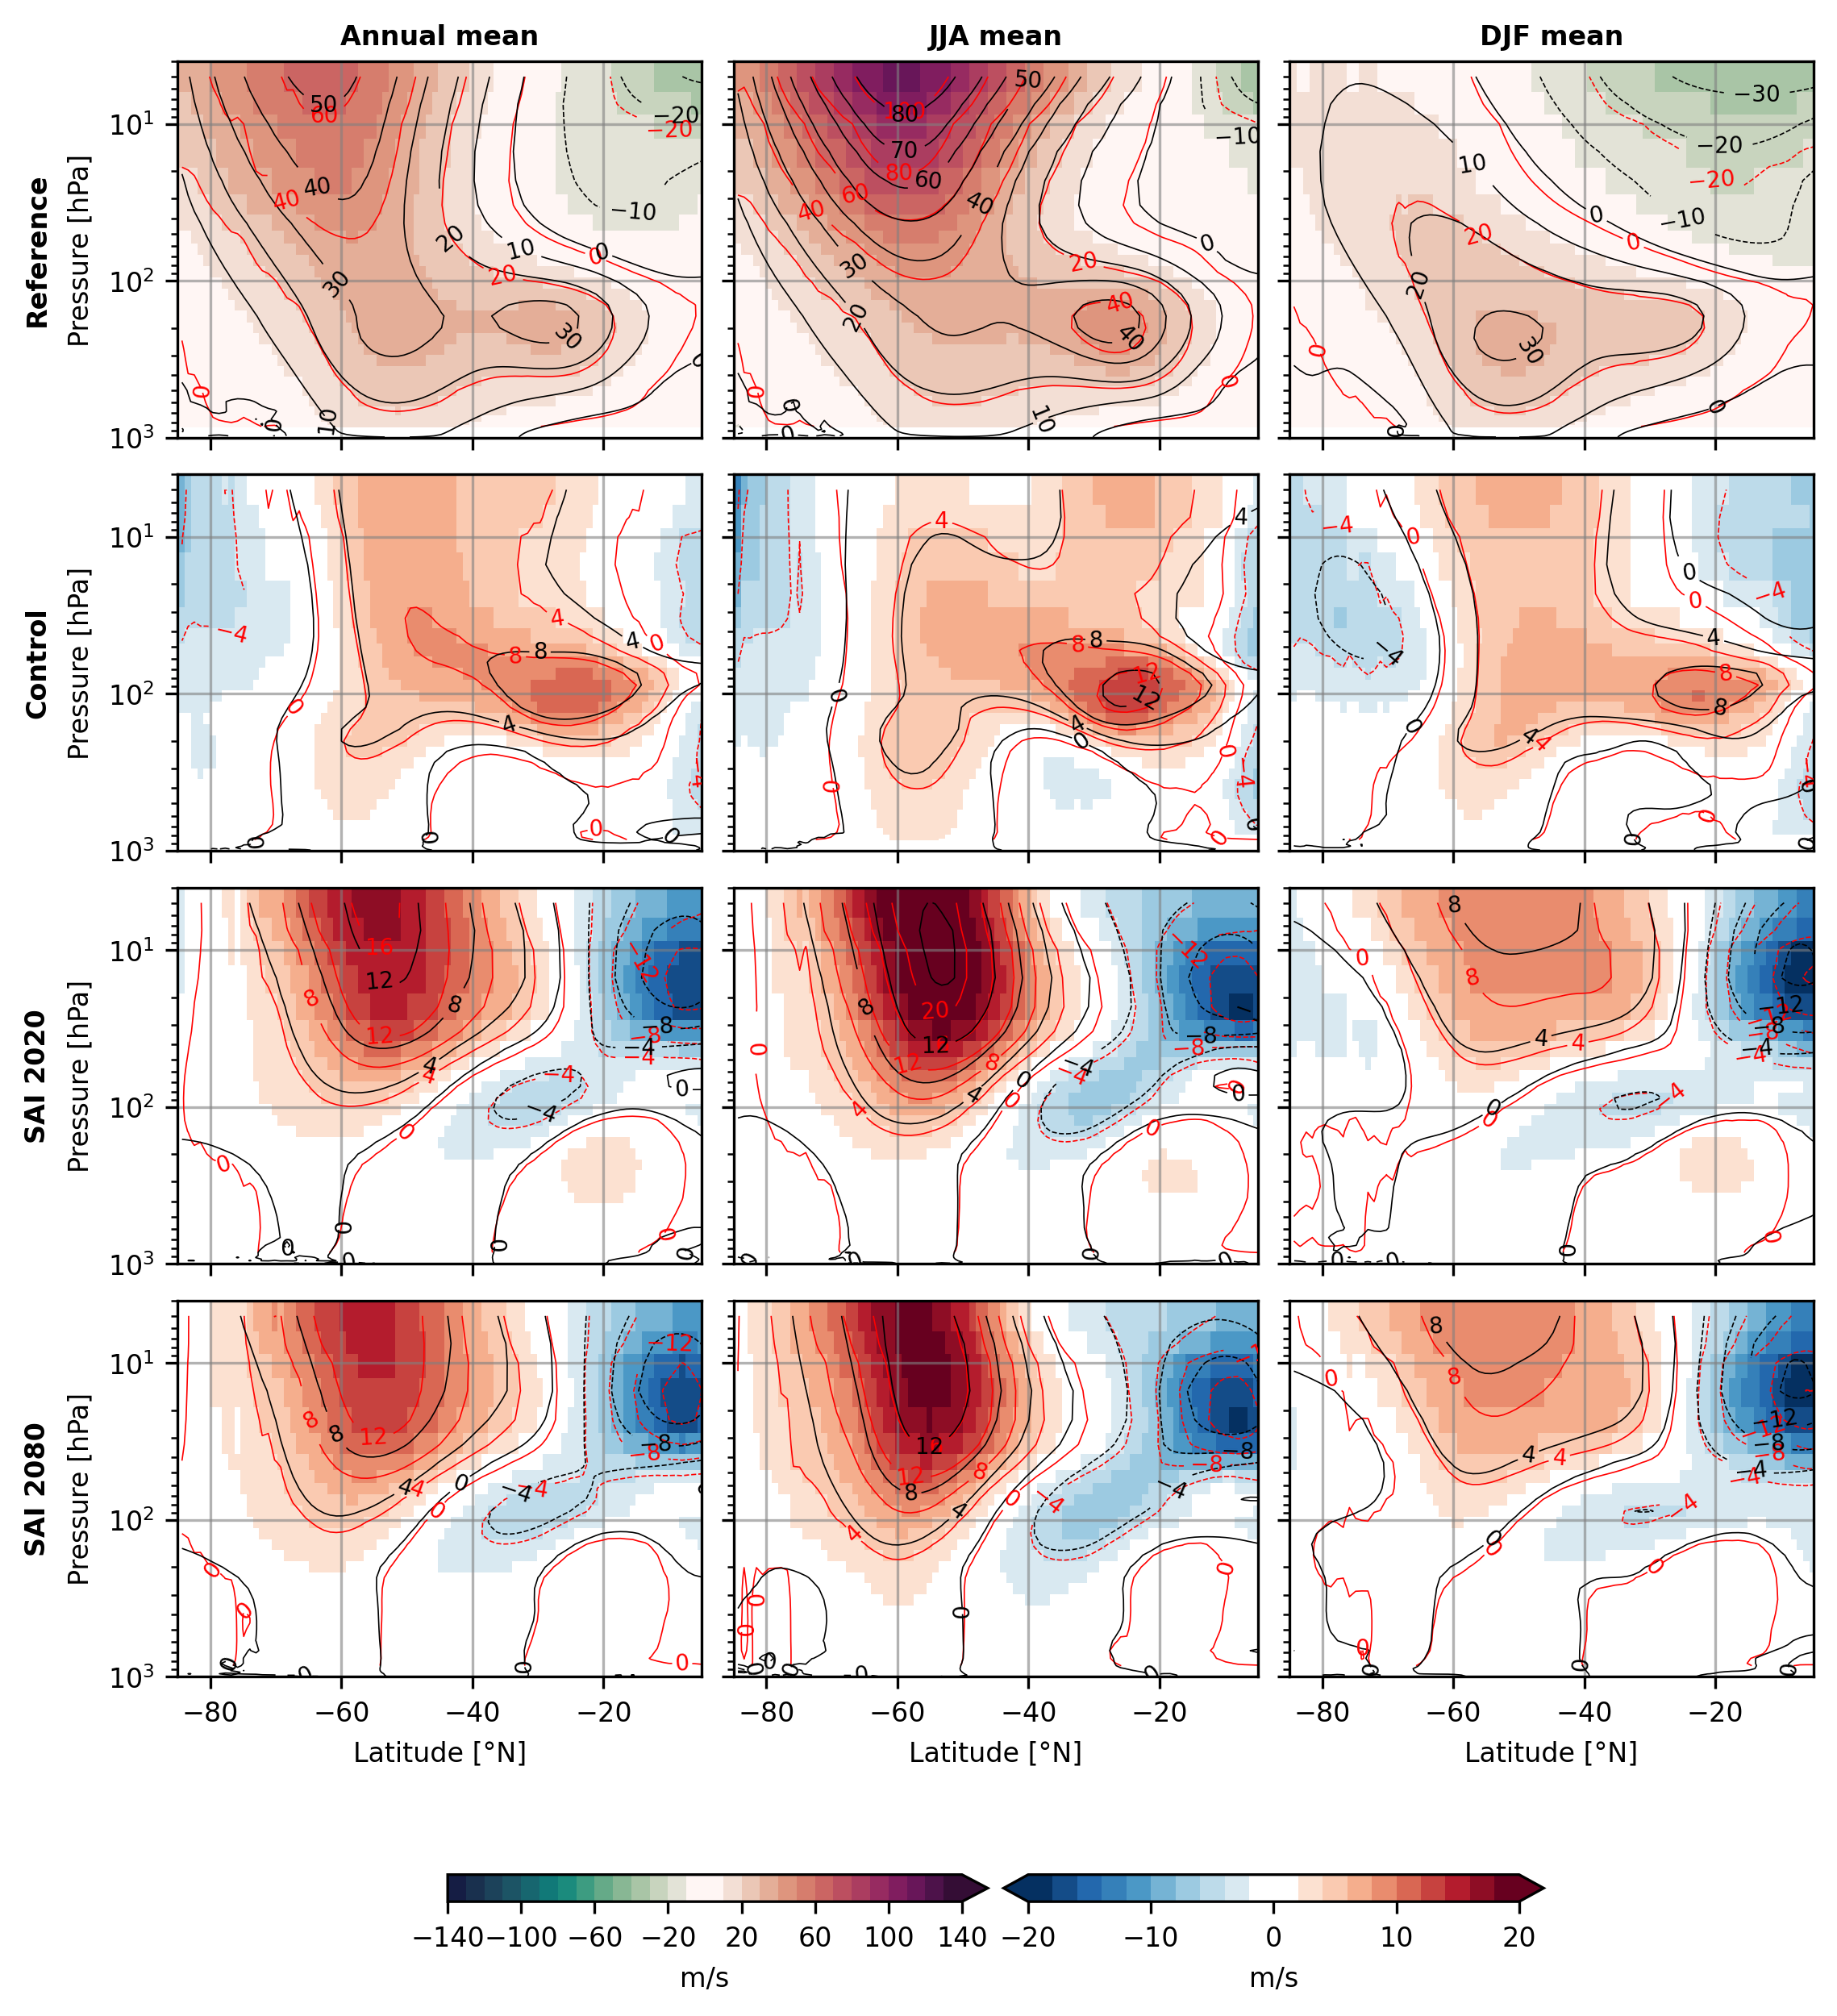

In [17]:
scen = ['i_c', 'cref', '20ref', '80ref']
scenJJA = ['iJJA_c', 'crefJJA', '20refJJA', '80refJJA']
scenDJF = ['iDJF_c', 'crefDJF', '20refDJF', '80refDJF']
scen_stack = np.asarray([scen, scenJJA, scenDJF])

scens_used = scen_stack.T.flatten()

sidelabels = ['Reference', 'Control', 'SAI 2020', 'SAI 2080']
toplabels = ['Annual mean', 'JJA mean', 'DJF mean']


comap = plt.get_cmap('cmo.curl')
bounds = np.concatenate([np.arange(-140,-1,10), np.arange(10,141,10)])
norm = colors.BoundaryNorm(bounds, comap.N)

comapd = mpl.colormaps['RdBu_r'].resampled(20)
newcolors = comapd(np.linspace(0,1,20))
white = np.array([1, 1, 1, 1])
newcolors[9:11,:] = white
newcmap = colors.ListedColormap(newcolors)

fig, axs = plt.subplots(4, 3, figsize=imgsize2, layout='constrained')
ax = axs.flatten()

font_kwargs = dict(fontweight="bold", fontsize=8)
add_headers(fig, col_headers=toplabels, row_headers=sidelabels, **font_kwargs)

for i,j in zip(ax,scens_used):    
    if j in scen_stack[:,0]:
        ima = UTzm[j].plot(ax=i, x='lat', y='plev', cmap=comap, norm=norm, add_colorbar=False)
    
        plot = UTzm[j].plot.contour(ax=i, x='lat', y='plev', colors='red', linewidths=0.4, vmin=-140, vmax=140, levels=15, kwargs=dict(inline=True))
        i.clabel(plot, fontsize='small', inline_spacing=1)
        
        plot = Uzm[j].plot.contour(ax=i, x='lat', y='plev', colors='k', linewidths=0.4, vmin=-140, vmax=140, levels=29, kwargs=dict(inline=True))
        i.clabel(plot, fontsize='small', inline_spacing=1)
    
        i.set_xlabel(None)
        i.set_ylabel(None)
        i.invert_yaxis()
        i.set_yscale('log')
        i.grid(color='gray', alpha=0.6)
        i.set_ylim(10**3,4)
        i.set_xlim(-85,-5)
        
    else:
        imb = UTzm[j].plot(ax=i, x='lat', y='plev', cmap=newcmap, vmin=-20, vmax=20, add_colorbar=False)
    
        plot = UTzm[j].plot.contour(ax=i, x='lat', y='plev', colors='red', linewidths=0.4, vmin=-20, vmax=20, levels=11, kwargs=dict(inline=True))
        i.clabel(plot, fontsize='small', inline_spacing=1)

        plot = Uzm[j].plot.contour(ax=i, x='lat', y='plev', colors='k', linewidths=0.4, vmin=-16, vmax=16, levels=9, kwargs=dict(inline=True))
        i.clabel(plot, fontsize='small', inline_spacing=1)
    
        i.set_xlabel(None)
        i.set_ylabel(None)
        i.invert_yaxis()
        i.set_yscale('log')
        i.grid(color='gray', alpha=0.6)
        i.set_ylim(10**3,4)
        i.set_xlim(-85,-5)
    
    if i in axs[:,1:].flatten():
        i.set_yticklabels([])
    
    if i in axs[:,0].flatten():
        i.set_ylabel('Pressure [hPa]')
    
    if i in axs[:-1,:].flatten():
        i.set_xticklabels([])
    
    if i in axs[-1,:].flatten():
        i.set_xlabel('Latitude [°N]')


plt.colorbar(ima, ax=axs[:,:2], shrink=0.5, location='bottom', label=r'm/s', extend='max', ticks=[-140,-100,-60,-20,20,60,100,140], spacing='proportional').minorticks_off()
plt.colorbar(imb, ax=axs[:,1:], shrink=0.5, location='bottom', label=r'm/s', extend='both')


if save == True: plt.savefig(savepath+'UT_U_zmdiff_full.png');


## Annual mean plots

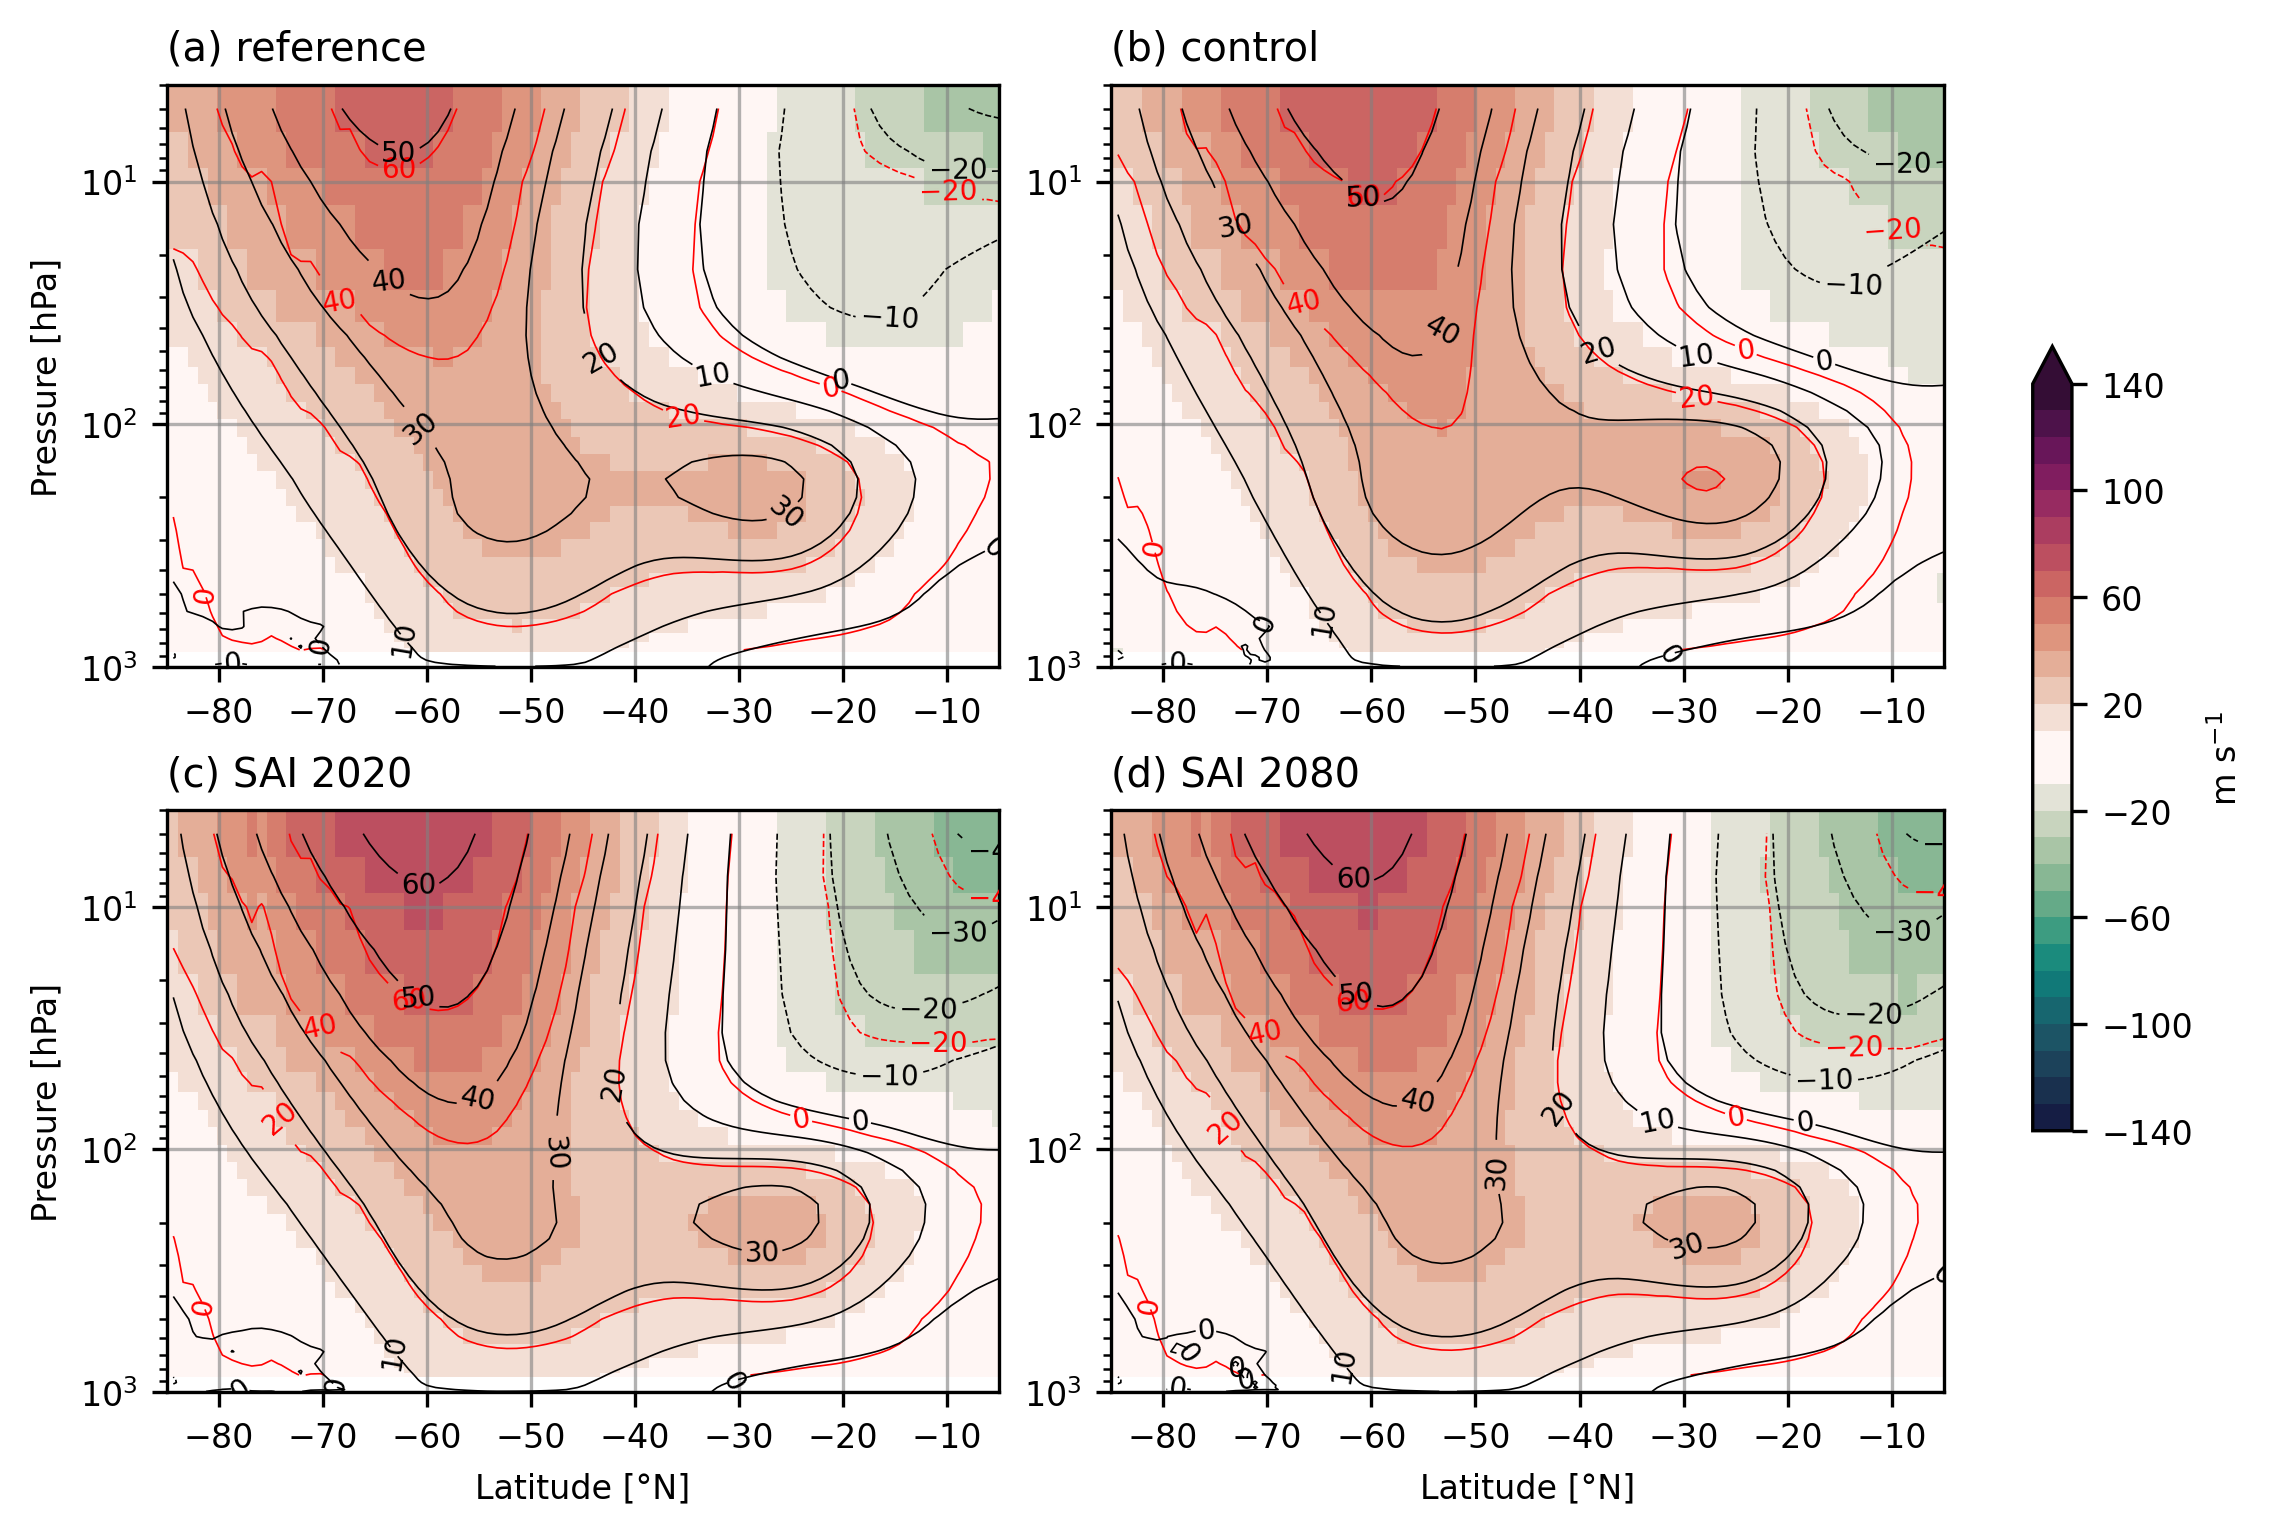

In [18]:
scen_used = ['i_c', 'f_c', 'f_20', 'f_80']
labels = ['(a) reference', '(b) control', '(c) SAI 2020', '(d) SAI 2080']
timesel = 'ann'

UTplot()


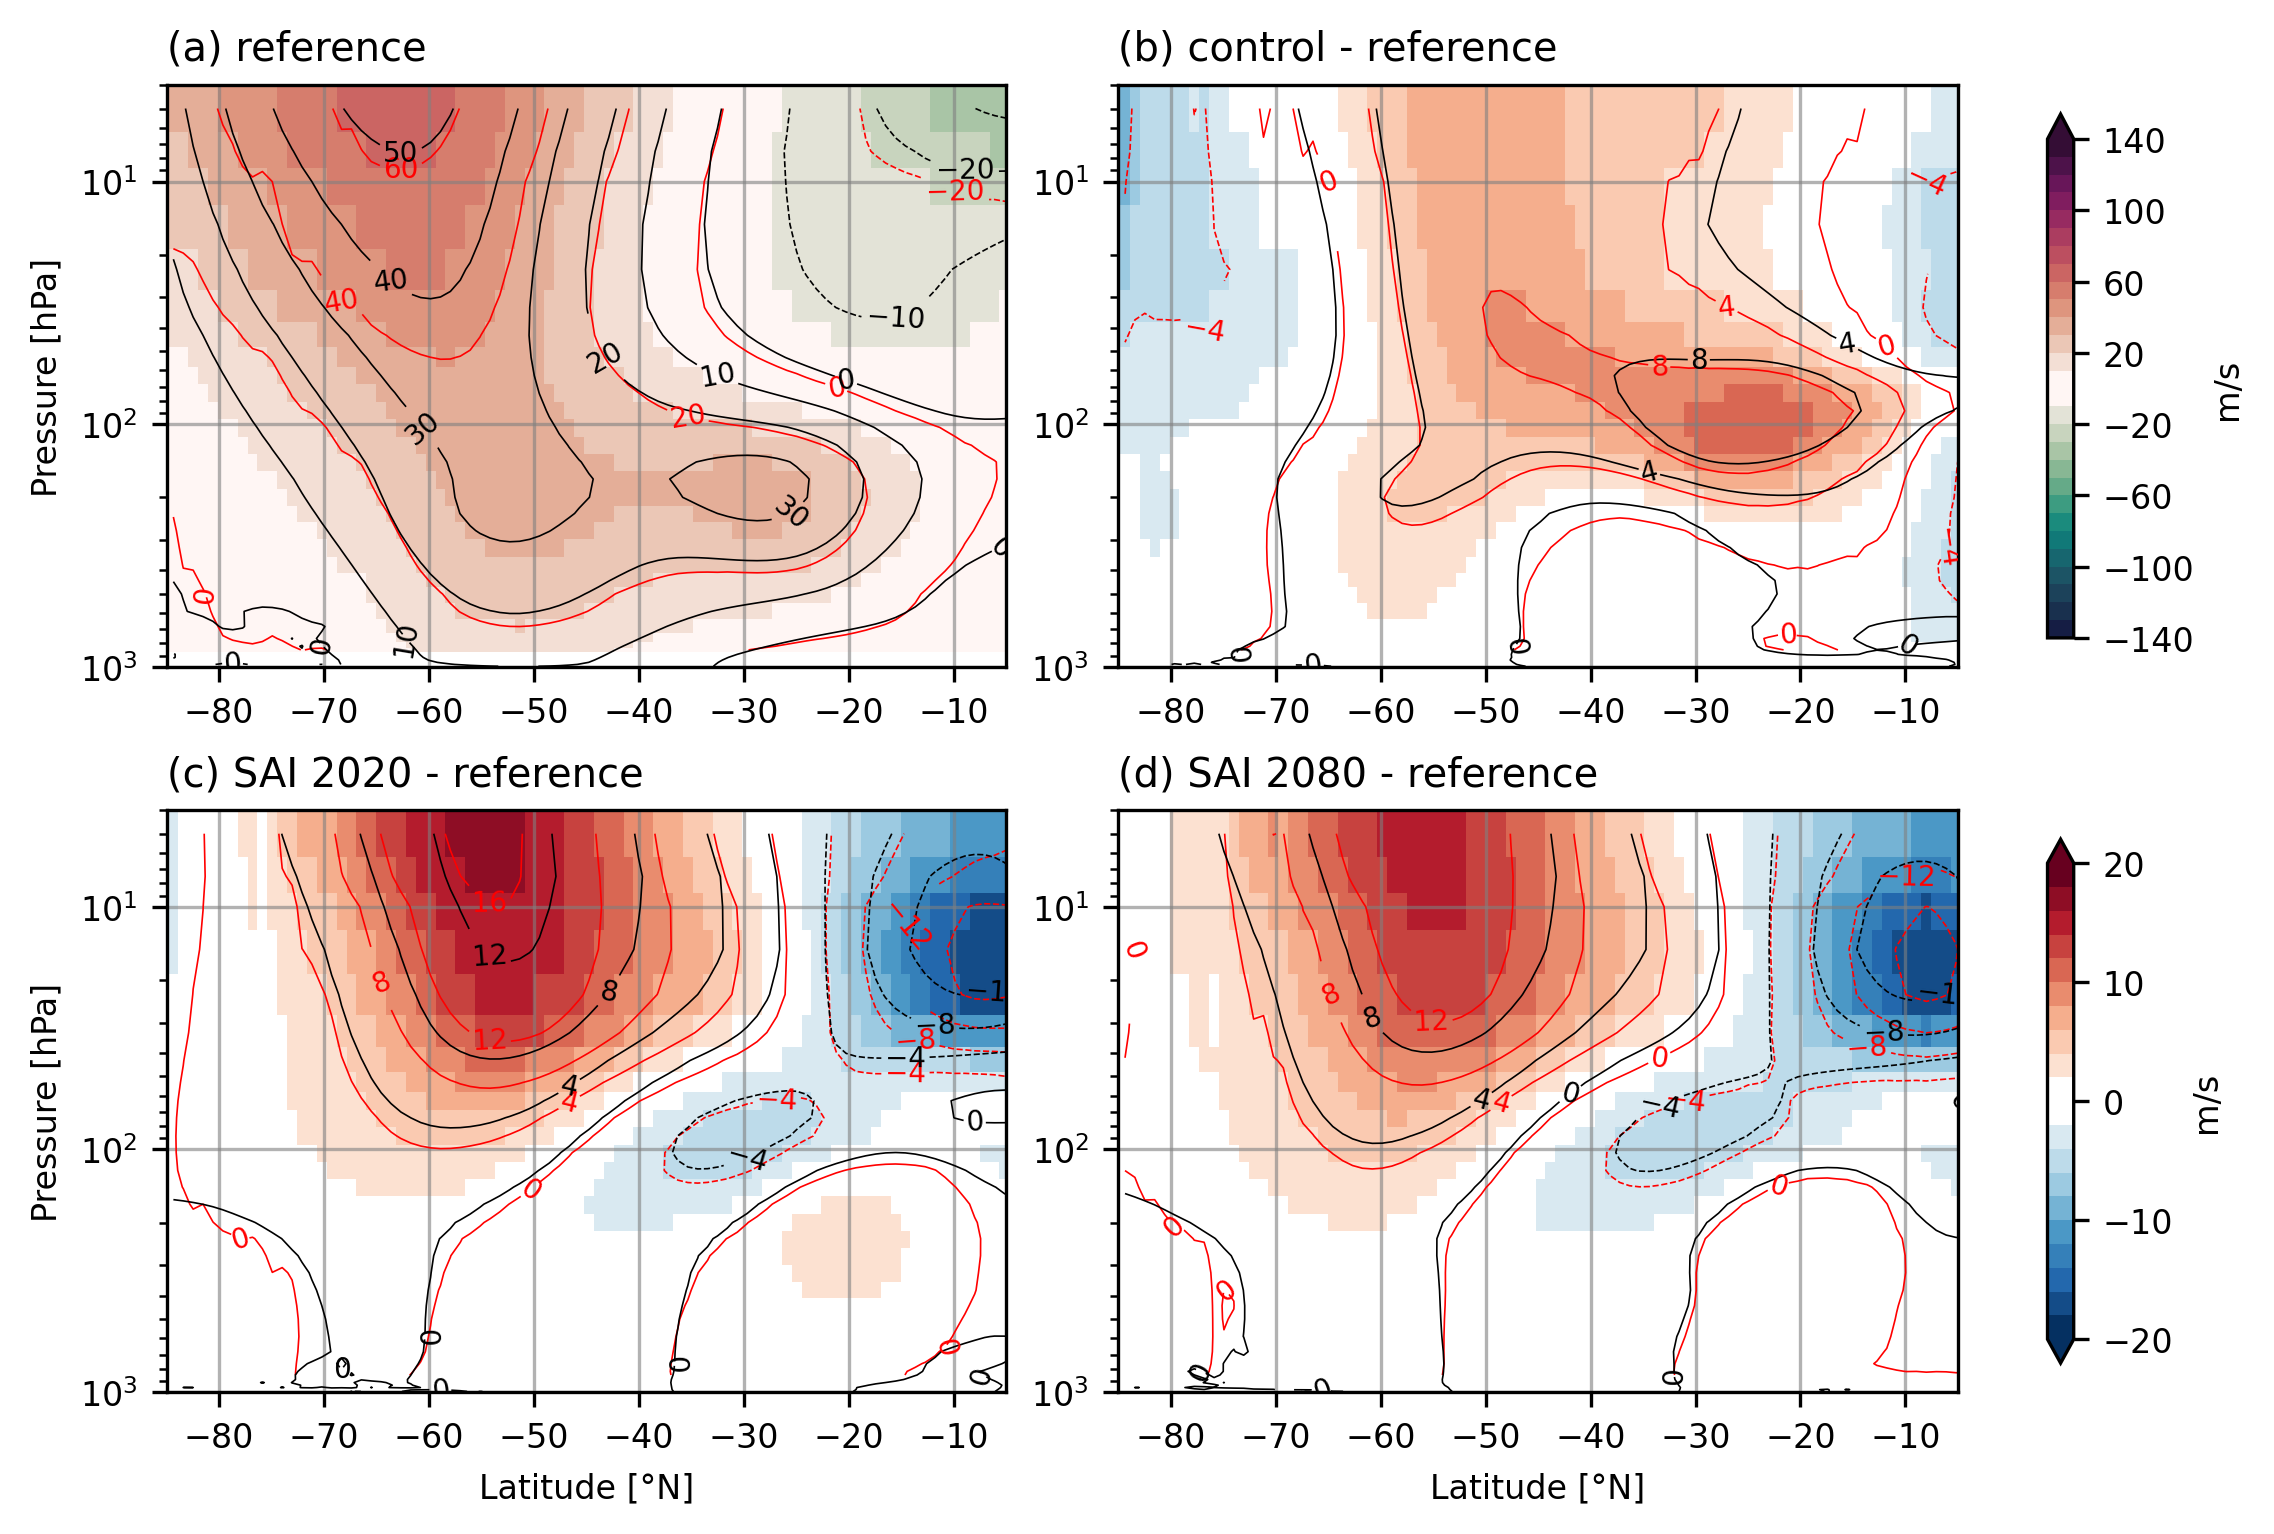

In [19]:
scen_used = ['i_c', 'cref', '20ref', '80ref']
labels = ['(a) reference', '(b) control - reference', '(c) SAI 2020 - reference', '(d) SAI 2080 - reference']
timesel = 'ann'

UTdiffplot()

## JJA mean plots

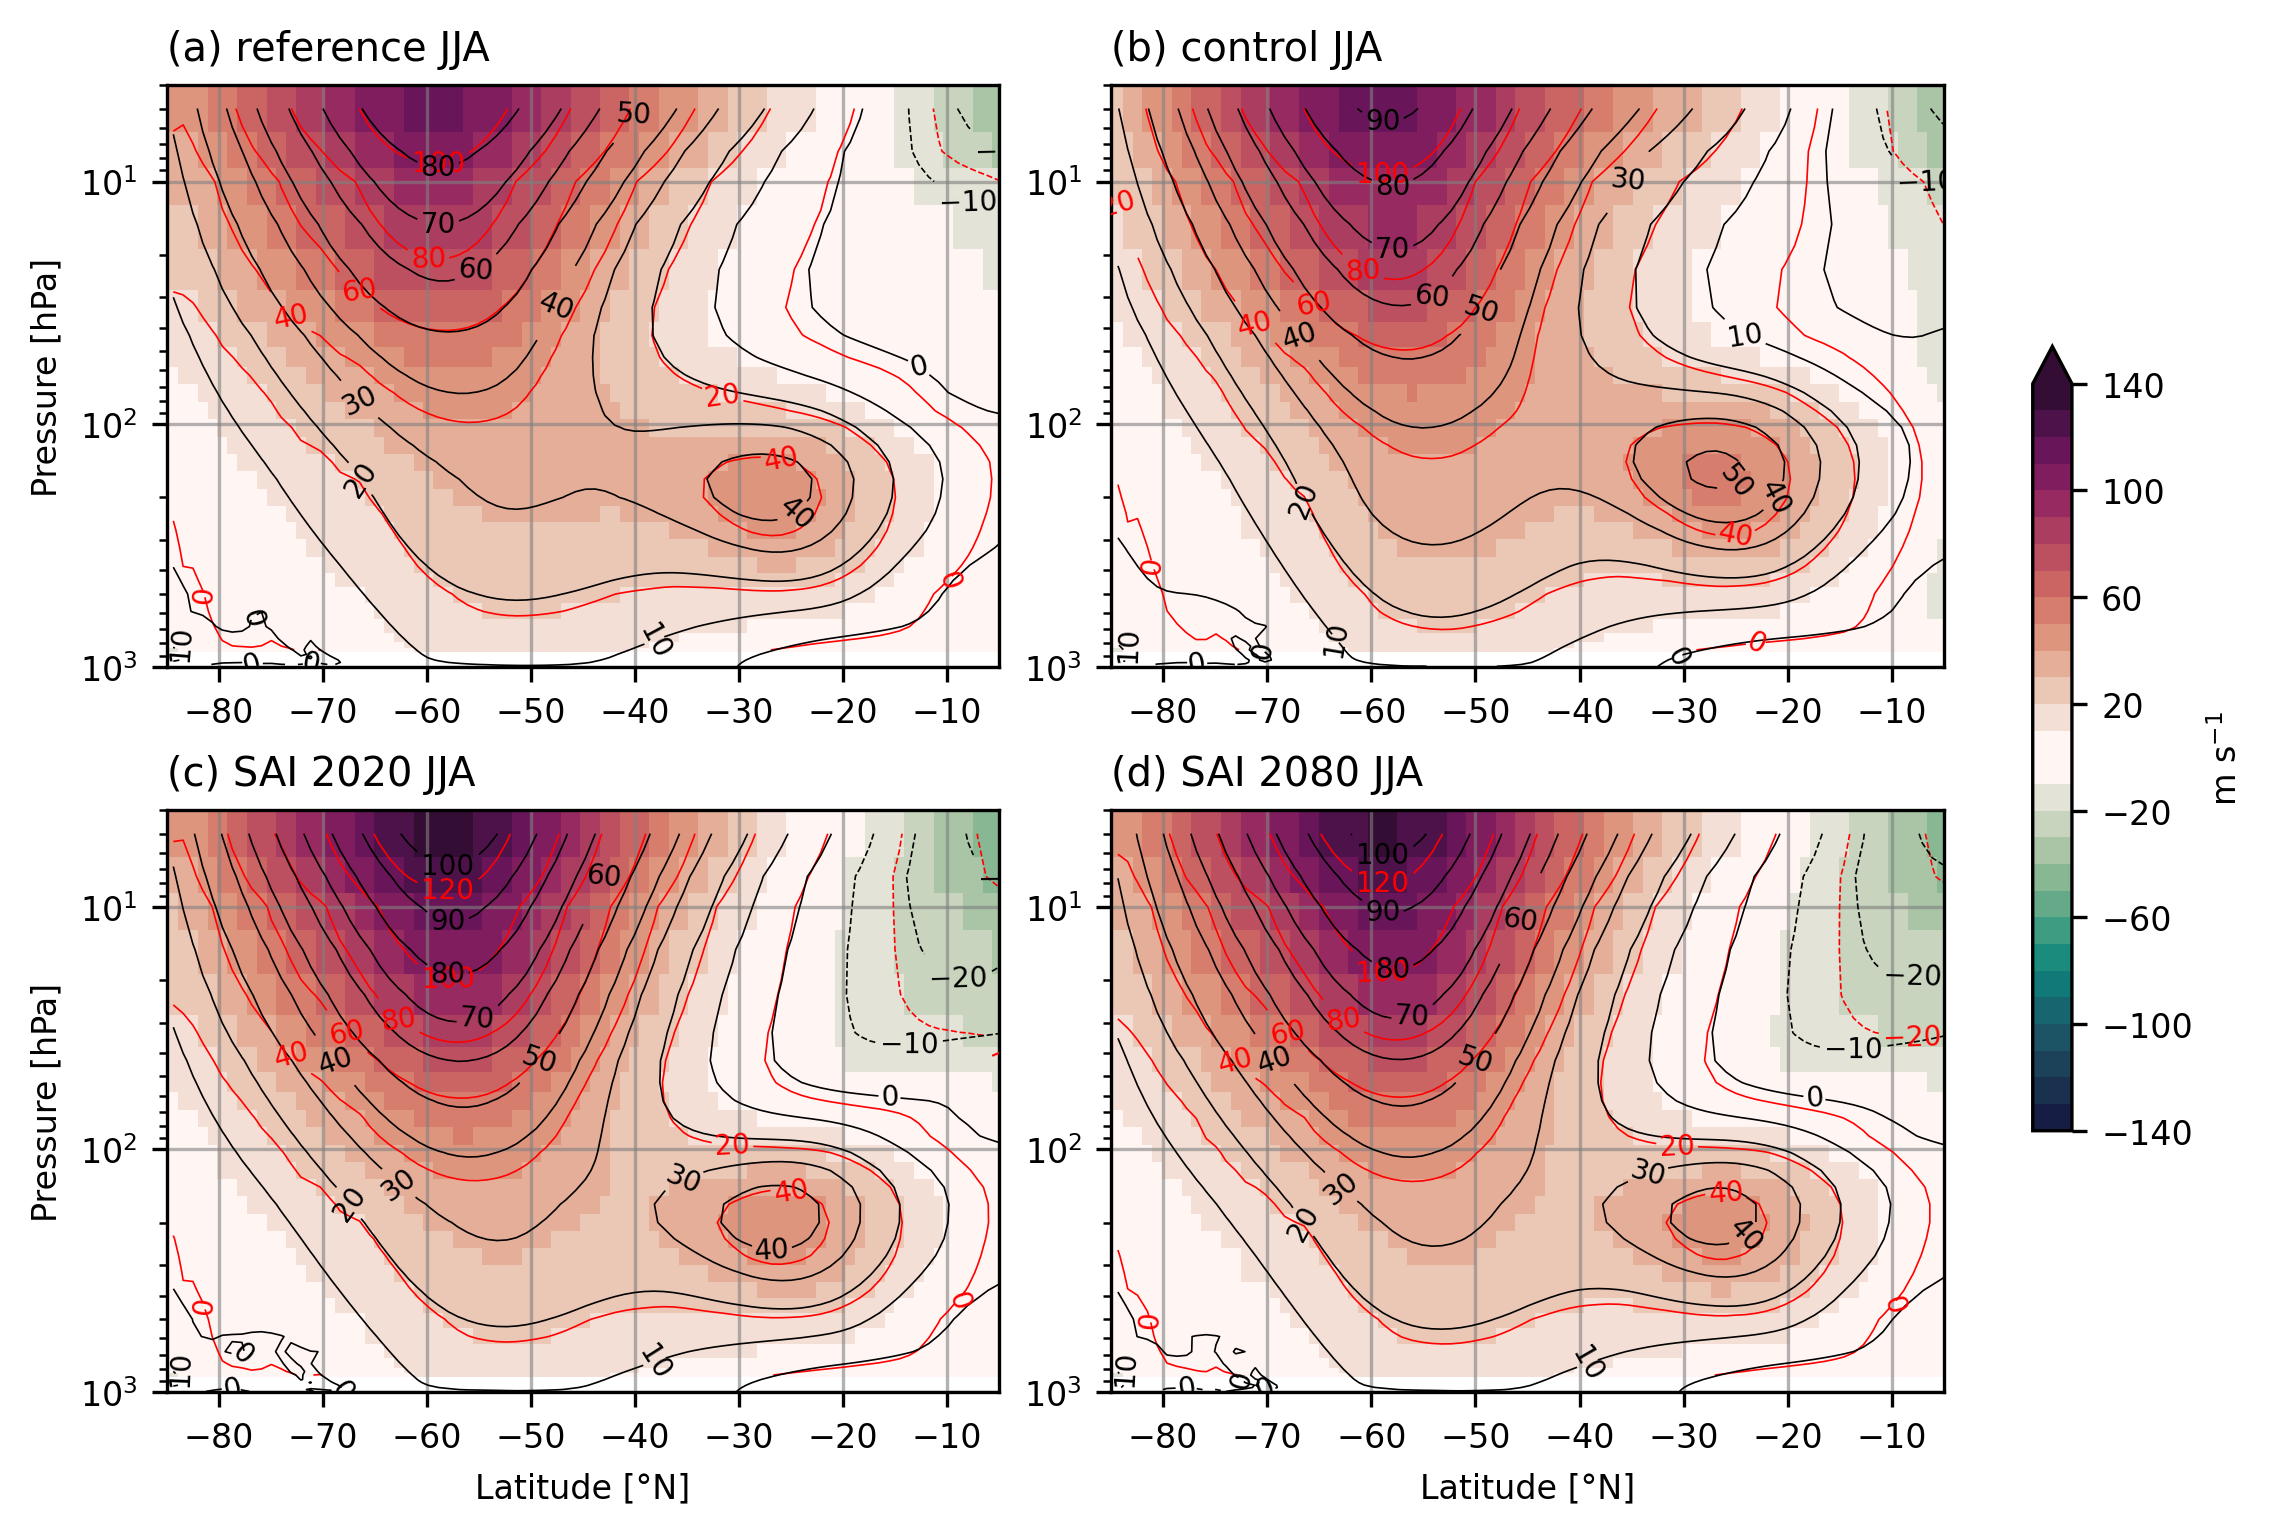

In [20]:
scen_used = ['iJJA_c', 'fJJA_c', 'fJJA_20', 'fJJA_80']
labels = ['(a) reference JJA', '(b) control JJA', '(c) SAI 2020 JJA', '(d) SAI 2080 JJA']
timesel = 'JJA'

UTplot()

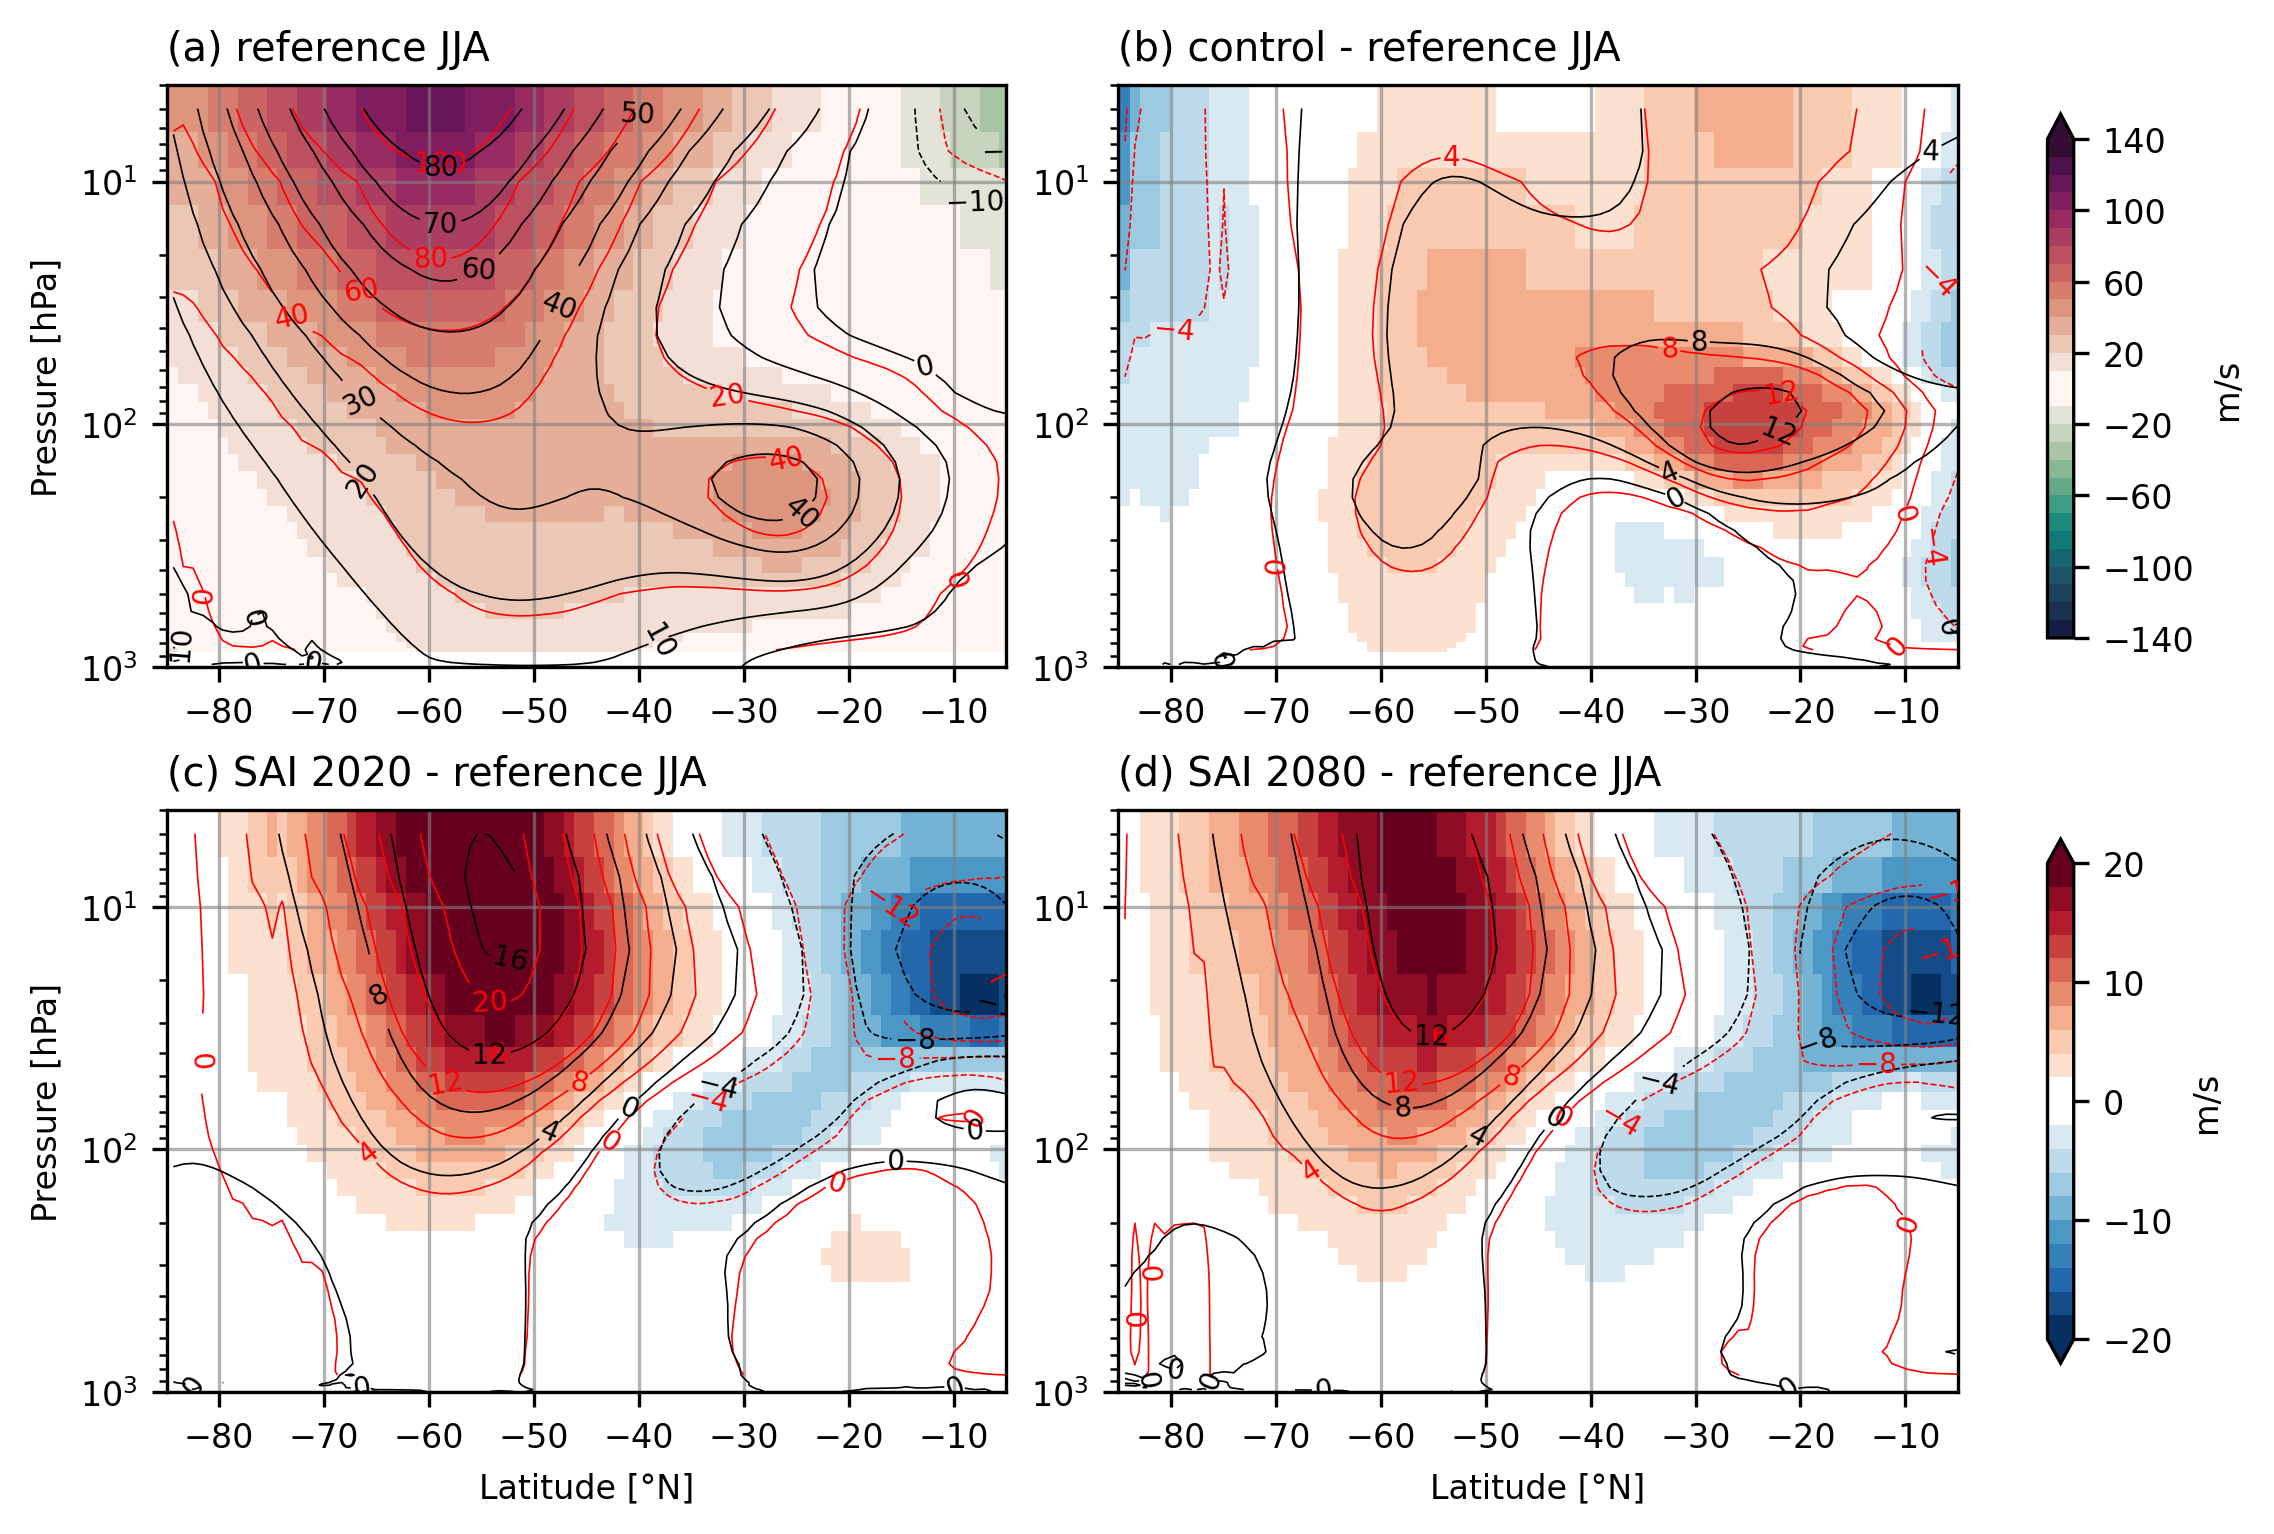

In [21]:
scen_used = ['iJJA_c', 'crefJJA', '20refJJA', '80refJJA']
labels = ['(a) reference JJA', '(b) control - reference JJA', '(c) SAI 2020 - reference JJA', '(d) SAI 2080 - reference JJA']
timesel = 'JJA'

UTdiffplot()

## DJF mean plots

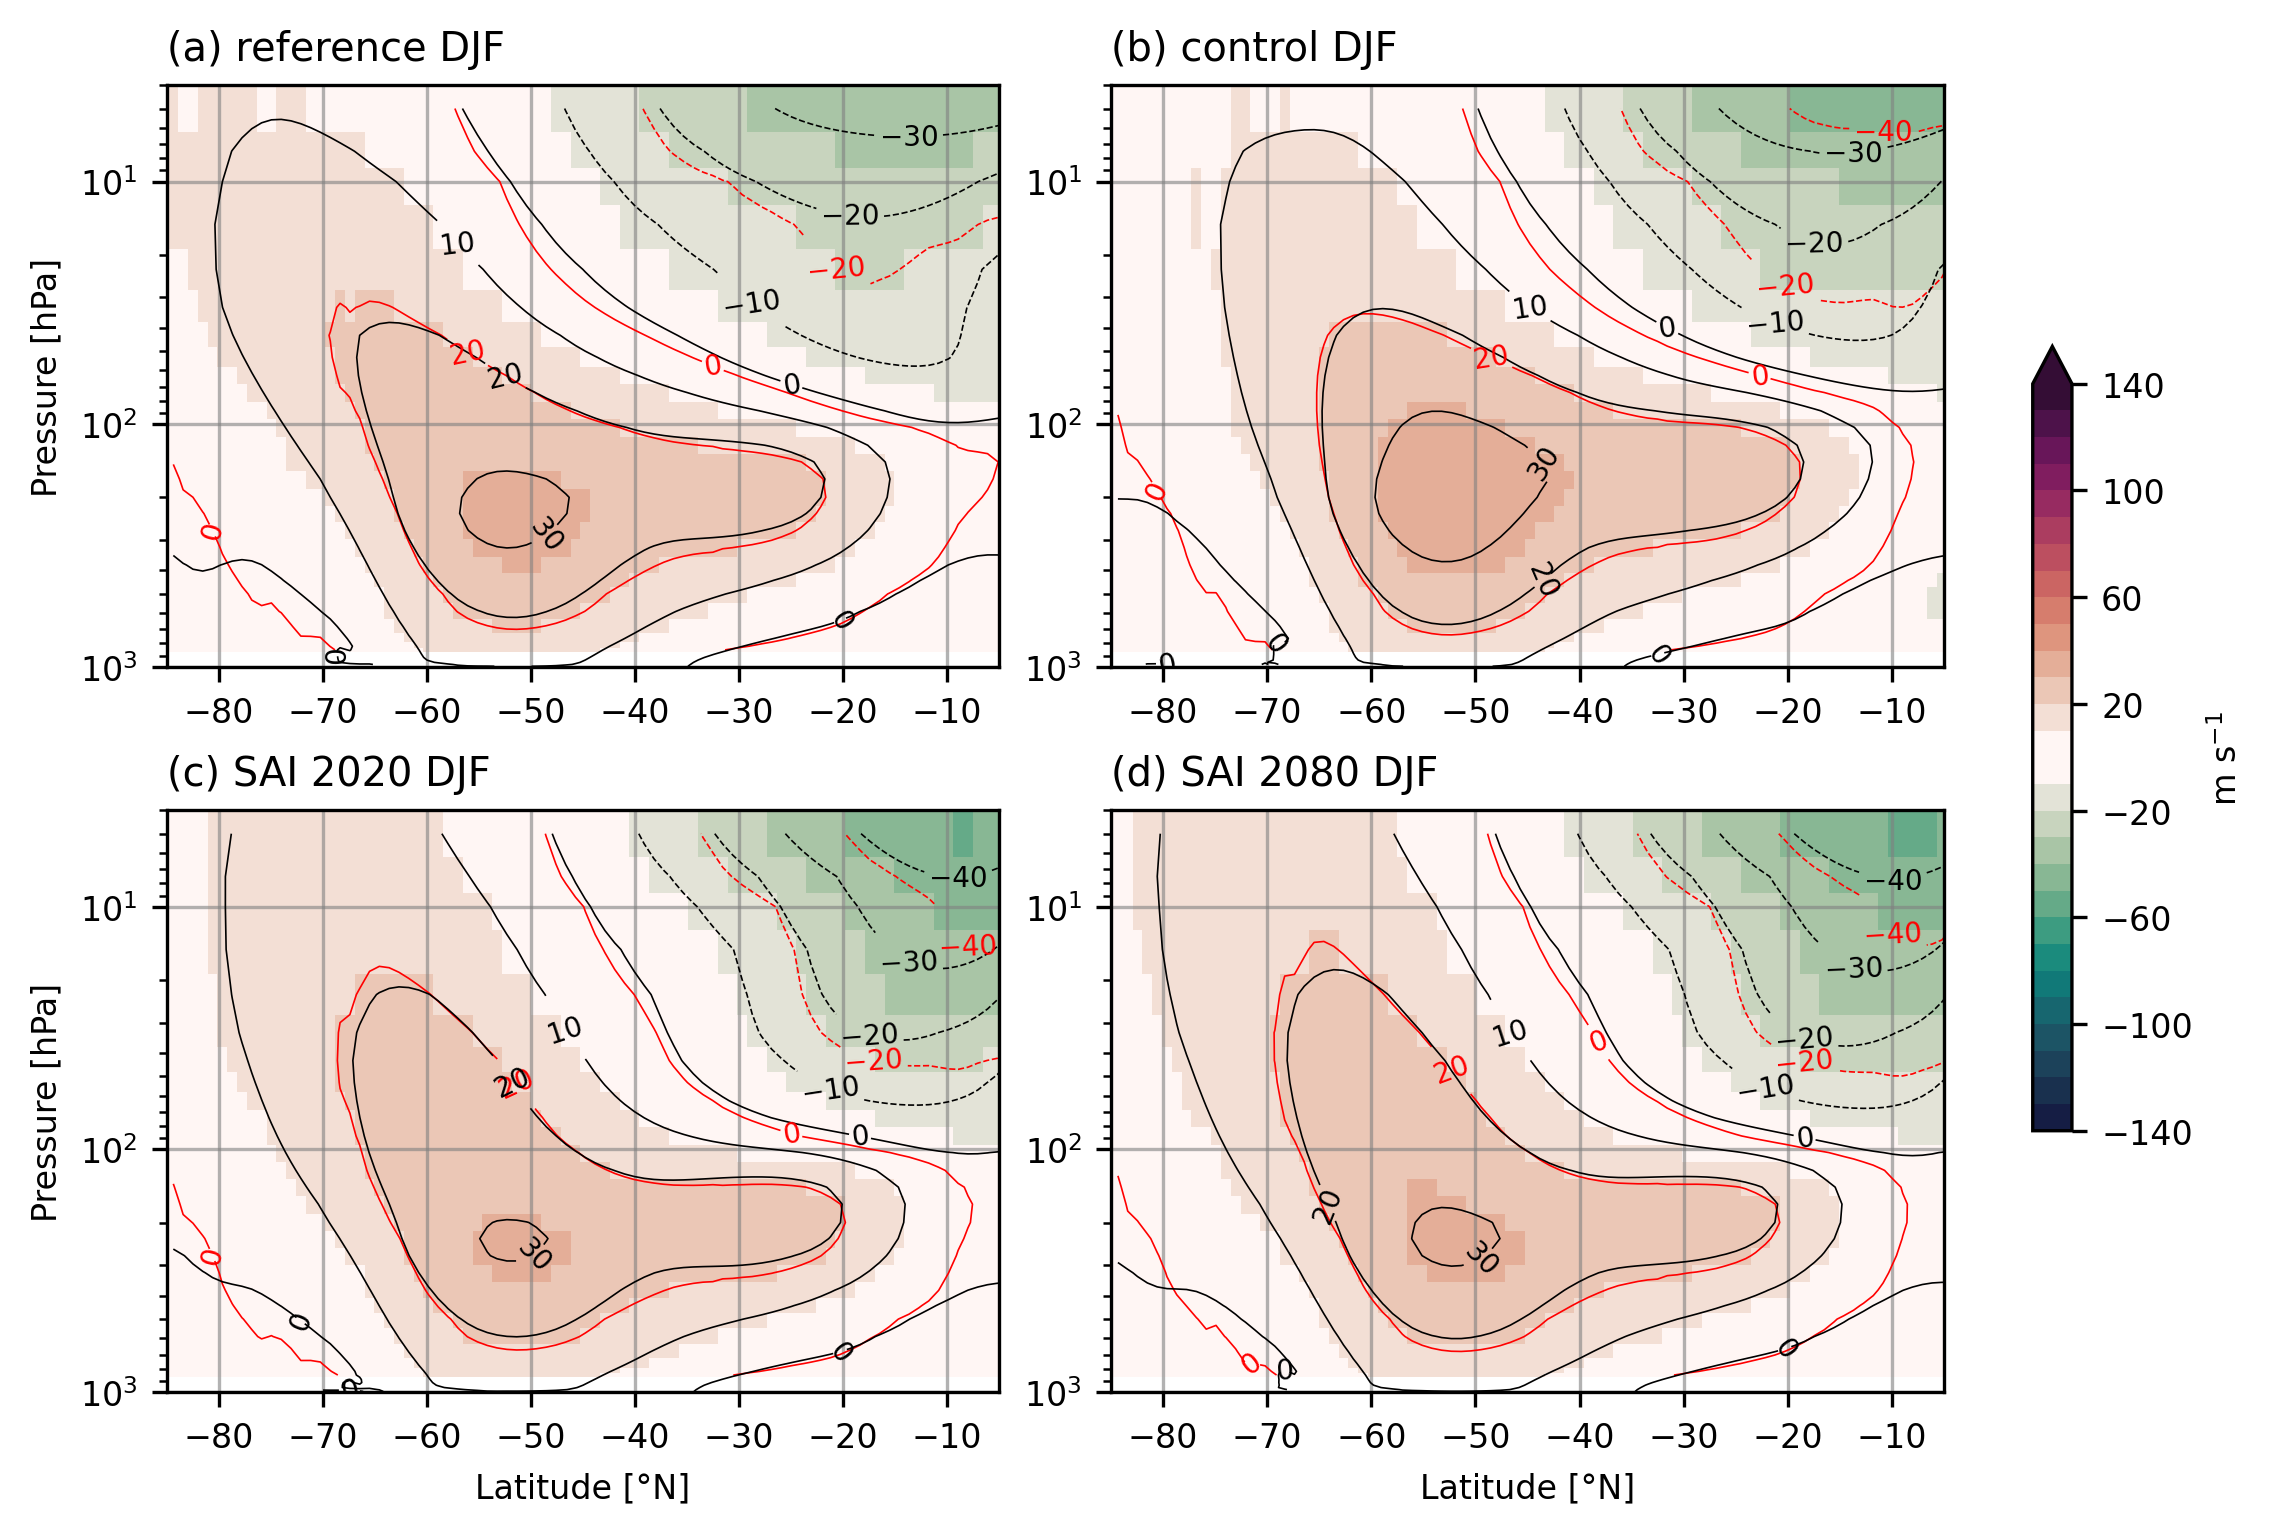

In [22]:
scen_used = ['iDJF_c', 'fDJF_c', 'fDJF_20', 'fDJF_80']
labels = ['(a) reference DJF', '(b) control DJF', '(c) SAI 2020 DJF', '(d) SAI 2080 DJF']
timesel = 'DJF'

UTplot()

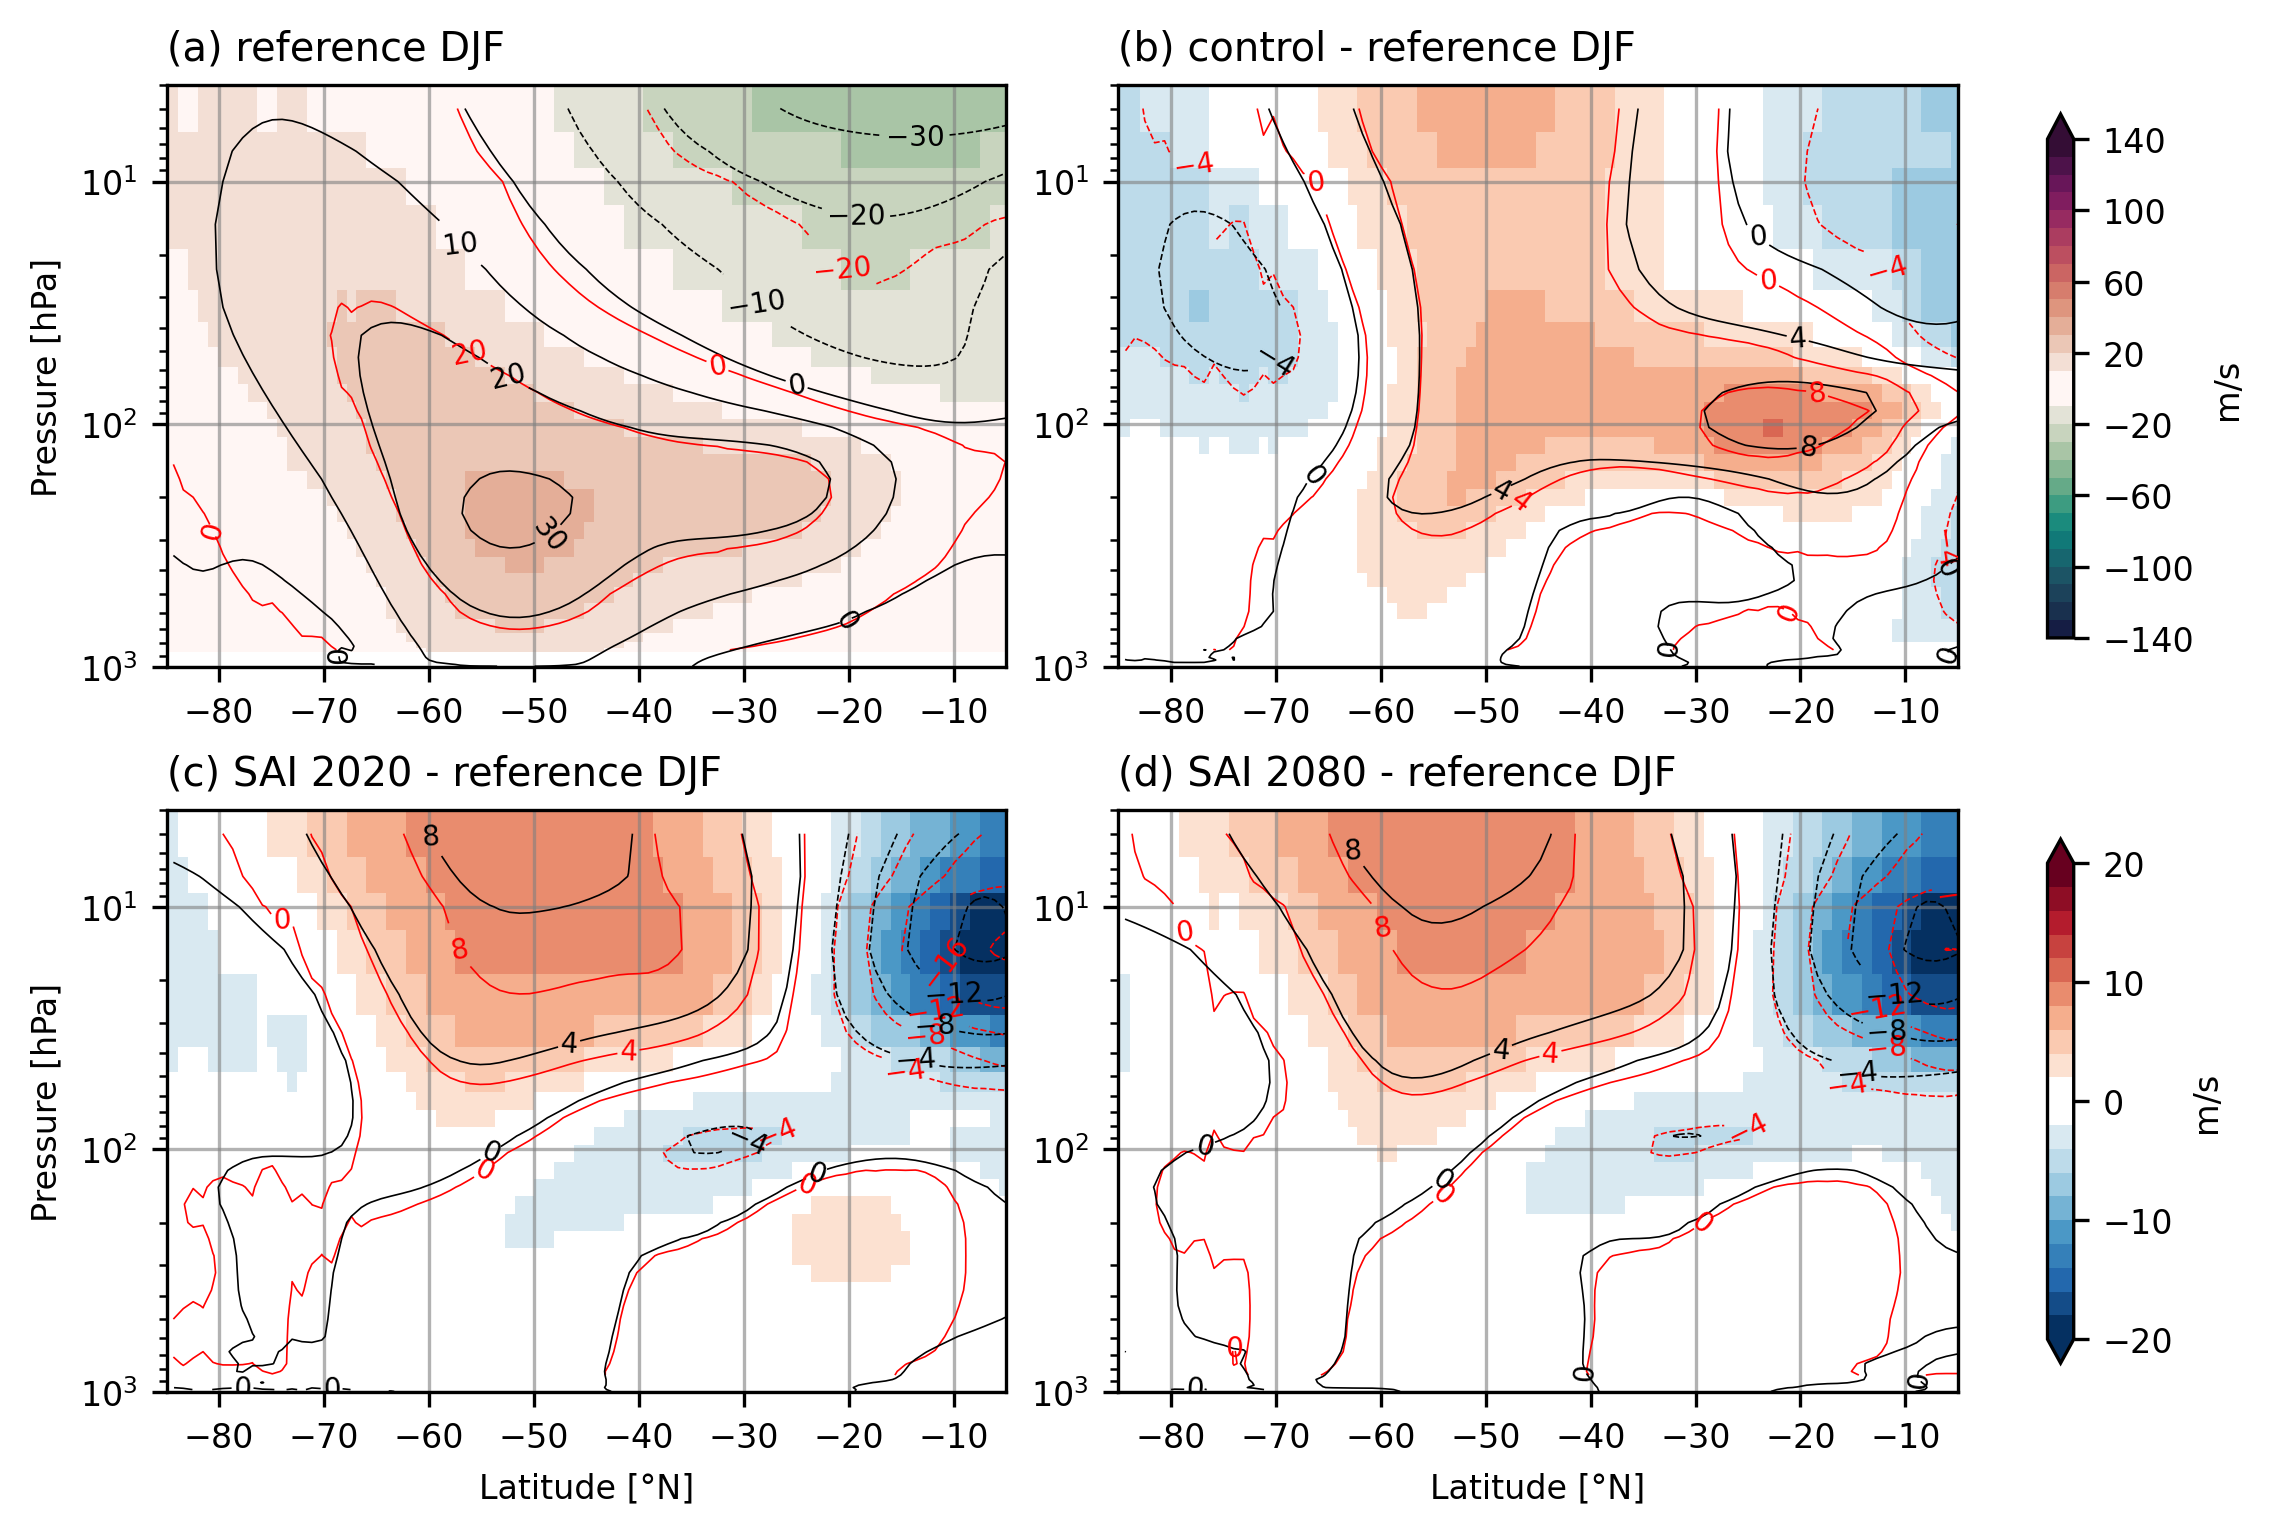

In [23]:
scen_used = ['iDJF_c', 'crefDJF', '20refDJF', '80refDJF']
labels = ['(a) reference DJF', '(b) control - reference DJF', '(c) SAI 2020 - reference DJF', '(d) SAI 2080 - reference DJF']
timesel = 'DJF'

UTdiffplot()